In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from lifelines.utils import concordance_index  # C-index
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, confusion_matrix


In [3]:
file_path = 'E:/HTWD/pyradiomics_train_data-Copy.csv'
file_path_test = 'E:/HTWD/test_data_greyvalues_pyradiomics.csv'

In [5]:
days_of_interest = [0, 3, 5, 7, 10, 12, 14]

# Function to load and filter the data
def load_and_filter_data(file_path, days):
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Filter the dataframe based on days
        df_filtered = df[df['day'].isin(days)]
        
        return df_filtered
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file {file_path} is empty.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Load and filter training data
df = load_and_filter_data(file_path, days_of_interest)

# Load and filter test data
df_test = load_and_filter_data(file_path_test, days_of_interest)

# Check if the dataframes were loaded successfully before proceeding
if df is not None and df_test is not None:
    # Continue with further data processing or analysis
    print("Data loaded and filtered successfully.")
else:
    print("Data loading failed. Please check the error messages above.")

Data loaded and filtered successfully.


In [7]:
# Function to pivot and prepare the dataset
def pivot_and_prepare_data(df):
    df_pivot = df.pivot_table(index='well', columns='day', values=[col for col in df.columns if col not in ['well', 'day', 'diagnosis']])
    df_pivot.columns = [f'{feat}_day{day}' for feat, day in df_pivot.columns]
    df_final = pd.merge(df_pivot, df[['well', 'diagnosis']].drop_duplicates(), on='well')
    X = df_final.drop(columns=['diagnosis', 'well'])
    y = df_final['diagnosis'].map({'relapsed': 1, 'controlled': 0})
    return X, y
X, y = pivot_and_prepare_data(df)
# Now split the pivoted dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Prepare the external test set (same pivoting process as train/val set)
X_test, y_test = pivot_and_prepare_data(df_test)

In [9]:
# Define the feature selectors and models
feature_selectors = {
    'Lasso': SelectFromModel(Lasso(alpha=0.01, random_state=42)),
    'PCA': PCA(n_components=0.95),  
    'RFE': RFE(LogisticRegression(max_iter=3000, random_state=42)),
    'SelectKBest': SelectKBest(score_func=f_classif, k=10),
}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced'),
    'SVC': SVC(probability=True, random_state=42),  
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Days of interest
days = [0, 3, 5, 7, 10, 12, 14]

# Initialize dictionaries to store metrics across days
metrics_by_day_train = {}
metrics_by_day_test = {}
metrics_by_day_val = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop over feature selectors and models
for fs_name, selector in feature_selectors.items():
    print(f"Using feature selector: {fs_name}")
    for model_name, model in models.items():
        # Create a combined key for feature selector and model
        key = f"{fs_name} + {model_name}"

        # Initialize lists to store metrics across days for each feature selector + model combination
        metrics_by_day_train[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}
        metrics_by_day_test[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}
        metrics_by_day_val[key] = {'roc_auc': [], 'c_index': [], 'f1_score': []}

        for day_idx, day in enumerate(days):
            # Aggregate features up to the current day
            days_up_to_current = days[:day_idx+1]
            X_train_day = X_train.loc[:, [col for col in X_train.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
            X_test_day = X_test.loc[:, [col for col in X_test.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
            X_val_day = X_val.loc[:, [col for col in X_val.columns if any(f'_day{d}' in col for d in days_up_to_current)]]

            # Skip if no features are available for the current day
            if X_train_day.shape[1] == 0 or X_test_day.shape[1] == 0 or X_val_day.shape[1] == 0:
                print(f"Skipping day {day} because no features are available.")
                continue

            # Create a pipeline with variance filtering, scaling, and the feature selector
            pipeline = Pipeline(steps=[
                ('variance_filter', VarianceThreshold(threshold=1e-5)),
                ('scaler', StandardScaler()),  
                ('feature_selection', selector),
                ('model', model)
            ])

            # Perform cross-validation on the training set
            print(f"Cross-validating for day {day}...")
            y_pred_prob_cv = cross_val_predict(pipeline, X_train_day, y_train, cv=kf, method='predict_proba')[:, 1]
            auc_train = roc_auc_score(y_train, y_pred_prob_cv)
            c_index_train = concordance_index(y_train, y_pred_prob_cv)
            f1_train = f1_score(y_train, (y_pred_prob_cv > 0.5).astype(int))

            # Store metrics for training set
            metrics_by_day_train[key]['roc_auc'].append(auc_train)
            metrics_by_day_train[key]['c_index'].append(c_index_train)
            metrics_by_day_train[key]['f1_score'].append(f1_train)

            # Fit the pipeline on the entire training set and predict on the test set
            print(f"Fitting and predicting on test set for day {day}...")
            pipeline.fit(X_train_day, y_train)
            y_pred_prob_test = pipeline.predict_proba(X_test_day)[:, 1]
            auc_test = roc_auc_score(y_test, y_pred_prob_test)
            c_index_test = concordance_index(y_test, y_pred_prob_test)
            f1_test = f1_score(y_test, (y_pred_prob_test > 0.5).astype(int))

            # Store metrics for test set
            metrics_by_day_test[key]['roc_auc'].append(auc_test)
            metrics_by_day_test[key]['c_index'].append(c_index_test)
            metrics_by_day_test[key]['f1_score'].append(f1_test)

            # Validate on the external validation set
            print(f"Validating on validation set for day {day}...")
            y_pred_prob_val = pipeline.predict_proba(X_val_day)[:, 1]
            auc_val = roc_auc_score(y_val, y_pred_prob_val)
            c_index_val = concordance_index(y_val, y_pred_prob_val)
            f1_val = f1_score(y_val, (y_pred_prob_val > 0.5).astype(int))

            # Store metrics for validation set
            metrics_by_day_val[key]['roc_auc'].append(auc_val)
            metrics_by_day_val[key]['c_index'].append(c_index_val)
            metrics_by_day_val[key]['f1_score'].append(f1_val)

# Convert the ROC-AUC, C-index, and F1-score results across all days to DataFrames
metrics_train_df = pd.DataFrame(metrics_by_day_train)
metrics_test_df = pd.DataFrame(metrics_by_day_test)
metrics_val_df = pd.DataFrame(metrics_by_day_val)

# Save the DataFrames to CSV for further analysis
metrics_train_df.to_csv("E:/HTWD/metrics_train_all_days.csv")
metrics_test_df.to_csv("E:/HTWD/metrics_test_all_days.csv")
metrics_val_df.to_csv("E:/HTWD/metrics_val_all_days.csv")

Using feature selector: Lasso
Cross-validating for day 0...
Fitting and predicting on test set for day 0...
Validating on validation set for day 0...
Cross-validating for day 3...
Fitting and predicting on test set for day 3...
Validating on validation set for day 3...
Cross-validating for day 5...
Fitting and predicting on test set for day 5...
Validating on validation set for day 5...
Cross-validating for day 7...
Fitting and predicting on test set for day 7...
Validating on validation set for day 7...
Cross-validating for day 10...
Fitting and predicting on test set for day 10...
Validating on validation set for day 10...
Cross-validating for day 12...
Fitting and predicting on test set for day 12...
Validating on validation set for day 12...
Cross-validating for day 14...
Fitting and predicting on test set for day 14...
Validating on validation set for day 14...
Cross-validating for day 0...
Fitting and predicting on test set for day 0...
Validating on validation set for day 0...
C

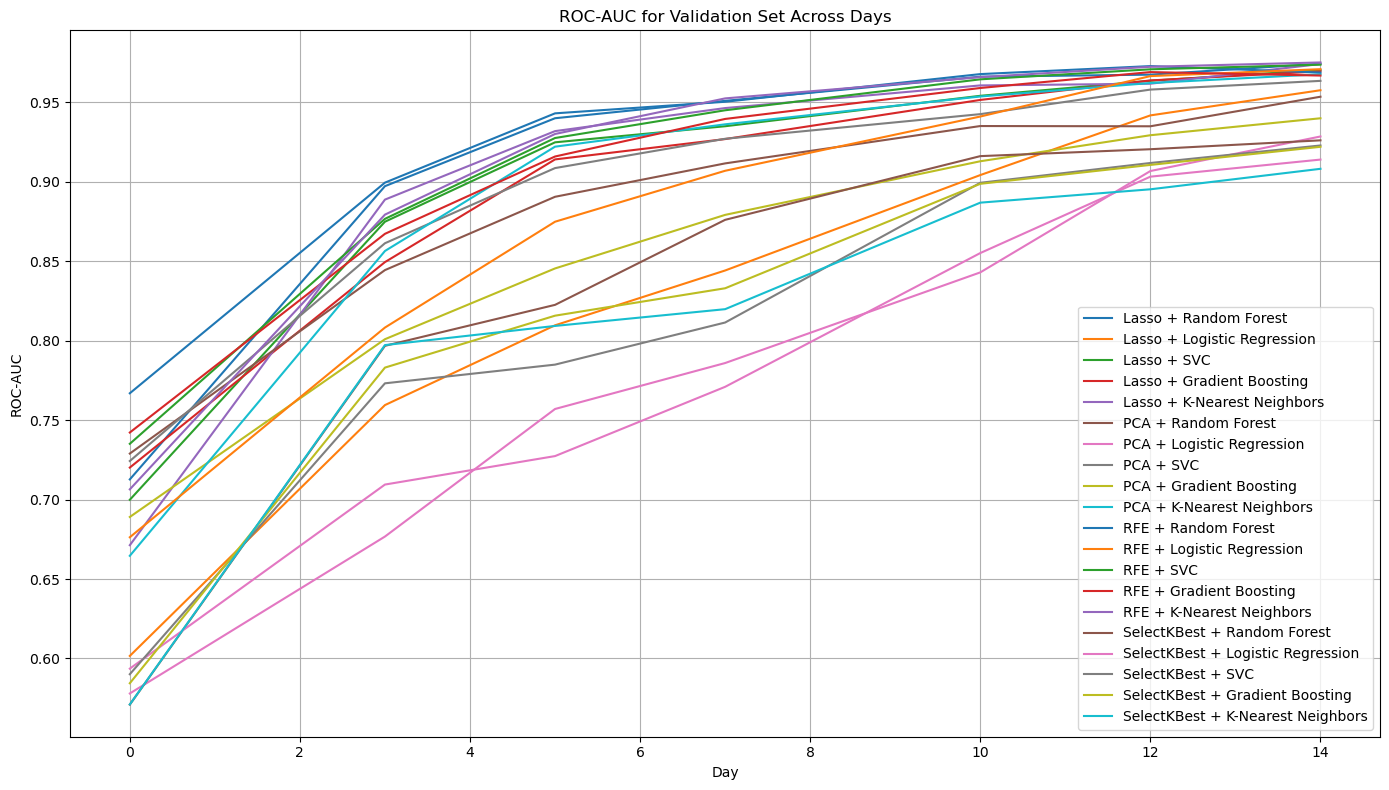

In [11]:
plt.figure(figsize=(14, 8))
for key in metrics_by_day_val.keys():
    plt.plot(days, metrics_by_day_val[key]['roc_auc'], label=key)
    
plt.title('ROC-AUC for Validation Set Across Days')
plt.xlabel('Day')
plt.ylabel('ROC-AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

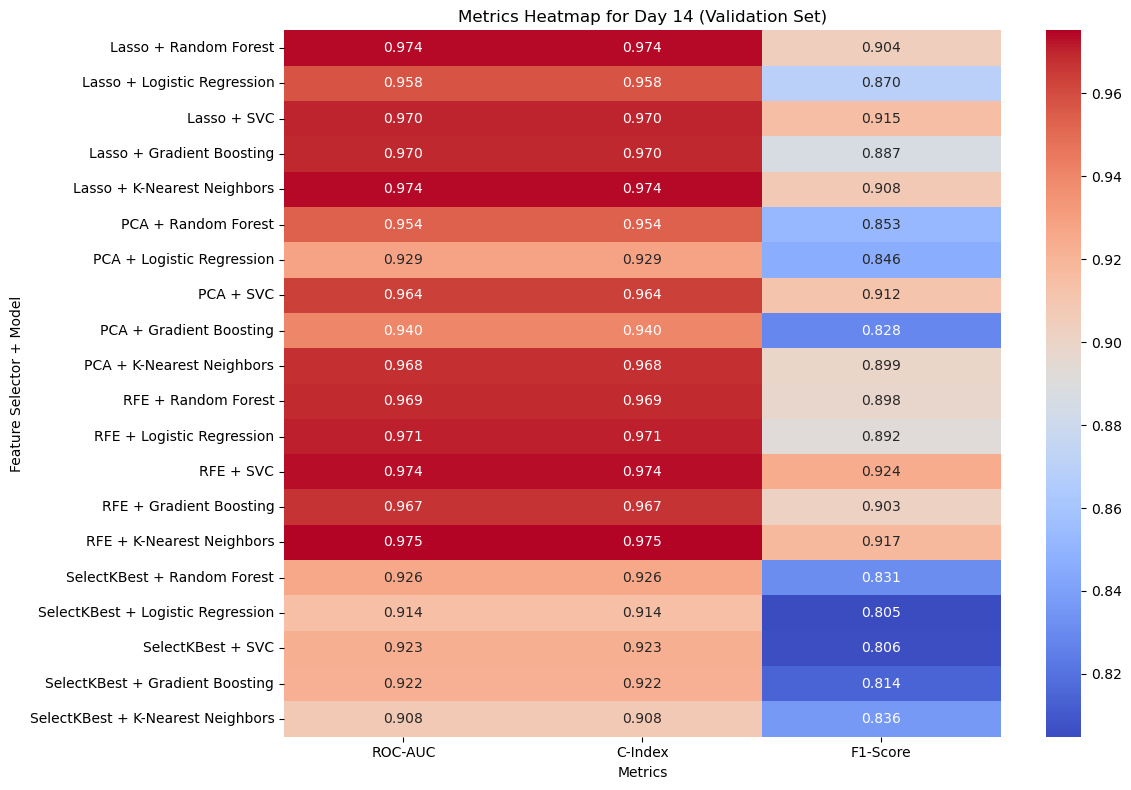

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmaps for day 14

# Extracting day 14 metrics for each metric type (ROC-AUC, C-index, F1-score)
roc_auc_day_14 = {key: metrics_by_day_val[key]['roc_auc'][-1] for key in metrics_by_day_val}
c_index_day_14 = {key: metrics_by_day_val[key]['c_index'][-1] for key in metrics_by_day_val}
f1_score_day_14 = {key: metrics_by_day_val[key]['f1_score'][-1] for key in metrics_by_day_val}

# Convert dictionaries to DataFrames
df_roc_auc_day_14 = pd.DataFrame.from_dict(roc_auc_day_14, orient='index', columns=['ROC-AUC'])
df_c_index_day_14 = pd.DataFrame.from_dict(c_index_day_14, orient='index', columns=['C-Index'])
df_f1_score_day_14 = pd.DataFrame.from_dict(f1_score_day_14, orient='index', columns=['F1-Score'])

# Combine the DataFrames for heatmap display
metrics_day_14 = pd.concat([df_roc_auc_day_14, df_c_index_day_14, df_f1_score_day_14], axis=1)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_day_14, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Metrics Heatmap for Day 14 (Validation Set)')
plt.xlabel('Metrics')
plt.ylabel('Feature Selector + Model')
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix, roc_curve

# Select a model and feature selector for confusion matrix and ROC curve (e.g., Random Forest + Lasso)
selected_key = 'Lasso + Random Forest'

# Predicted values for validation set on Day 14
y_pred_prob_val_day_14 = metrics_by_day_val[selected_key]['roc_auc'][-1]

# Convert probabilities to binary predictions for confusion matrix
y_val_pred_class_day_14 = (y_pred_prob_val_day_14 > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_class_day_14)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {selected_key} on Day 14 (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_val_day_14)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{selected_key} (Validation Day 14)')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.title(f'ROC Curve for {selected_key} on Day 14 (Validation Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 1 instead.